In [9]:
setwd("G:\\My Drive\\repos\\example-models\\knitr\\car-iar-poisson")
library("rstan")
library(gdata)
library(bayesplot)

ERROR: Error in library(bayesplot): there is no package called 'bayesplot'


# Notes:

# This creates a simple model:

In [10]:
writeLines(readLines('simple_iar.stan'))

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]
}
parameters {
  vector[N] phi;
  real sigma;
}
model {
  target += -0.5 * dot_self(phi[node1] - phi[node2]);

  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  sum(phi) ~ normal(0, 0.01 * N);
}


In [11]:
options(mc.cores = parallel::detectCores())  

In [12]:
source("scotland_data.R")

In [13]:
str(data)

List of 7
 $ N      : num 56
 $ y      : num [1:56] 9 39 11 9 15 8 26 7 6 20 ...
 $ E      : num [1:56] 1.4 8.7 3 2.5 4.3 2.4 8.1 2.3 2 6.6 ...
 $ x      : num [1:56] 16 16 10 24 10 24 10 7 7 16 ...
 $ adj    : num [1:264] 5 9 11 19 7 10 6 12 18 20 ...
 $ weights: num [1:264] 1 1 1 1 1 1 1 1 1 1 ...
 $ num    : num [1:56] 4 2 2 3 5 2 5 1 6 4 ...


In [14]:
(N = length(data$num))
 (N_edges = length(data$adj))

[1] 56

[1] 264

In [15]:
nbs = mungeCARdata4stan(data$adj, data$num);

mungeCARdata4stan = function(adjBUGS,numBUGS) {
  N = length(numBUGS); ##This is the number of regions to consider 
  nn = numBUGS;
  N_edges = length(adjBUGS) / 2;
  node1 = vector(mode="numeric", length=N_edges);
  node2 = vector(mode="numeric", length=N_edges);
  iAdj = 0;
  iEdge = 0;
  for (i in 1:N) {
    for (j in 1:nn[i]) {
      iAdj = iAdj + 1;
      if (i < adjBUGS[iAdj]) {
        iEdge = iEdge + 1;
        node1[iEdge] = i;
        node2[iEdge] = adjBUGS[iAdj];
      }
    }
  }
  return (list("N"=N,"N_edges"=N_edges,"node1"=node1,"node2"=node2));
}


In [16]:
data$adj

[1]  5  9 11 19  7 10  6 12 18 20 28  1 11 12 13 19  3  8  2 10 13 16 17  6  1
 [26] 11 17 19 23 29  2  7 16 22  1  5  9 12  3  5 11  5  7 17 19 31 32 35 25 29
 [51] 50  7 10 17 21 22 29  7  9 13 16 19 29  4 20 28 33 55 56  1  5  9 13 17  4
 [76] 18 55 16 29 50 10 16  9 29 34 36 37 39 27 30 31 44 47 48 55 56 15 26 29 25
[101] 29 42 43 24 31 32 55  4 18 33 45  9 15 16 17 21 23 25 26 34 43 50 24 38 42
[126] 44 45 56 14 24 27 32 35 46 47 14 27 31 35 18 28 45 56 23 29 39 40 42 43 51
[151] 52 54 14 31 32 37 46 23 37 39 41 23 35 36 41 46 30 42 44 49 51 54 23 34 36
[176] 40 41 34 39 41 49 52 36 37 39 40 46 49 53 26 30 34 38 43 51 26 29 34 42 24
[201] 30 38 48 49 28 30 33 56 31 35 37 41 47 53 24 31 46 48 49 53 24 44 47 49 38
[226] 40 41 44 47 48 52 53 54 15 21 29 34 38 42 54 34 40 49 54 41 46 47 49 34 38
[251] 49 51 52 18 20 24 27 56 18 24 30 33 45 55

In [17]:
data$num

[1]  4  2  2  3  5  2  5  1  6  4  4  3  4  3  3  6  6  6  5  3  3  2  6  8  3
[26]  4  4  4 11  6  7  4  4  9  5  4  5  6  5  5  7  6  4  5  4  6  6  4  9  3
[51]  4  4  4  5  5  6

In [18]:
source("mungeCARdata4stan.R")

In [19]:
nbs = mungeCARdata4stan(data$adj, data$num);
N = data$N;
node1 = nbs$node1;
node2 = nbs$node2;
N_edges = nbs$N_edges;

In [20]:
str(nbs)

List of 4
 $ N      : int 56
 $ N_edges: num 132
 $ node1  : num [1:132] 1 1 1 1 2 2 3 3 4 4 ...
 $ node2  : num [1:132] 5 9 11 19 7 10 6 12 18 20 ...


In [21]:
node1

[1]  1  1  1  1  2  2  3  3  4  4  4  5  5  5  5  6  7  7  7  7  9  9  9  9  9
 [26] 10 10 11 13 13 14 14 14 15 15 15 16 16 16 16 17 17 18 18 18 18 18 20 21 21
 [51] 23 23 23 23 23 24 24 24 24 24 24 24 24 25 25 26 26 26 27 27 27 28 28 29 29
 [76] 29 30 30 30 30 30 31 31 31 31 32 33 33 34 34 34 34 34 34 34 35 35 36 36 36
[101] 37 37 38 38 38 38 38 39 39 40 40 40 41 41 41 42 42 44 44 45 46 46 47 47 47
[126] 48 49 49 49 51 52 55

In [22]:
node2

[1]  5  9 11 19  7 10  6 12 18 20 28 11 12 13 19  8 10 13 16 17 11 17 19 23 29
 [26] 16 22 12 17 19 31 32 35 25 29 50 17 21 22 29 19 29 20 28 33 55 56 55 29 50
 [51] 29 34 36 37 39 27 30 31 44 47 48 55 56 26 29 29 42 43 31 32 55 33 45 34 43
 [76] 50 38 42 44 45 56 32 35 46 47 35 45 56 39 40 42 43 51 52 54 37 46 37 39 41
[101] 41 46 42 44 49 51 54 40 41 41 49 52 46 49 53 43 51 48 49 56 47 53 48 49 53
[126] 49 52 53 54 54 54 56

In [23]:
iar_stan = stan_model("simple_iar.stan");

In [24]:
fit_stan = sampling(iar_stan, data=list(N,N_edges,node1,node2), control=list(adapt_delta = 0.97, stepsize = 0.1), chains=2, warmup=9000, iter=10000, save_warmup=FALSE);

Warning message:
"There were 61 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

In [28]:
fit_icar_stan = sampling(iar_stan, data=list(N,N_edges,node1,node2), chains=3, warmup=4000, iter=5000, save_warmup=FALSE);


SAMPLING FOR MODEL 'simple_iar' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Warmup)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Warmup)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Warmup)
Chain 1: Iteration: 4001 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.609 seconds (Warm-up)
Chain 1:                0.394 seconds (Sampling)
Chain 1:                3.003 seconds (Tota

Warning message:
"There were 24 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

In [25]:
ofile = "simple_iar_stan_010K_iters.txt";

In [26]:
capture.output(print(fit_stan, digits=3, probs=c(0.025, 0.975)),file=ofile);

## BYM Predictor + offset Stan

In [30]:
writeLines(readLines('bym_predictor_plus_offset.stan'))

// use for Scotland dataset
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]

  int<lower=0> y[N];              // count outcomes
  vector[N] x;                    // predictor
  vector<lower=0>[N] E;           // exposure
}
transformed data {
  vector[N] log_E = log(E);
}
parameters {
  real beta0;                // intercept
  real beta1;                // slope

  real<lower=0> tau_theta;   // precision of heterogeneous effects
  real<lower=0> tau_phi;     // precision of spatial effects

  vector[N] theta;       // heterogeneous effects
  vector[N] phi;         // spatial effects
}
transformed parameters {
  real<lower=0> sigma_theta = inv(sqrt(tau_theta));  // convert precision to sigma
  real<lower=0> sigma_phi = inv(sqrt(tau_phi));      // convert precision to sigma
}
model {
  y ~ poisson_log(log_E + beta0 + beta1 * x + phi * sigma_phi + 

In [27]:
source("mungeCARdata4stan.R")  
source("scotland_data.R")
y = data$y;
x = 0.1 * data$x;
E = data$E;

nbs = mungeCARdata4stan(data$adj, data$num);
N = nbs$N;
node1 = nbs$node1;
node2 = nbs$node2;
N_edges = nbs$N_edges;


[1] 1.6 1.6 1.0 2.4 1.0 2.4

In [30]:
bym_scot_stanfit = stan("bym_predictor_plus_offset.stan", data=list(N,N_edges,node1,node2,y,x,E), control=list(adapt_delta = 0.97, stepsize = 0.1), chains=3, warmup=9000, iter=10000, save_warmup=FALSE);

In [31]:
print(bym_scot_stanfit, pars=c("beta0", "beta1", "sigma_phi", "tau_phi", "sigma_theta", "tau_theta", "mu[5]", "phi[5]", "theta[5]"), probs=c(0.025, 0.5, 0.975));

Inference for Stan model: bym_predictor_plus_offset.
3 chains, each with iter=10000; warmup=9000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

             mean se_mean   sd  2.5%   50% 97.5% n_eff Rhat
beta0       -0.28    0.00 0.17 -0.61 -0.28  0.03  1776    1
beta1        0.42    0.00 0.17  0.09  0.42  0.75  1727    1
sigma_phi    0.67    0.00 0.13  0.45  0.65  0.96  1214    1
tau_phi      2.51    0.03 1.00  1.09  2.34  4.95  1189    1
sigma_theta  0.48    0.00 0.07  0.36  0.47  0.63  1857    1
tau_theta    4.64    0.03 1.31  2.55  4.48  7.55  1848    1
mu[5]       14.20    0.05 3.42  8.45 13.83 21.73  4675    1
phi[5]       1.28    0.01 0.46  0.38  1.27  2.21  1700    1
theta[5]     0.41    0.01 0.68 -0.95  0.42  1.72  3170    1

Samples were drawn using NUTS(diag_e) at Wed Oct 02 16:34:47 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1

# BYM2 Model with Rinla:



In [34]:
writeLines(readLines('bym2.stan'))

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]

  int<lower=0> y[N];              // count outcomes
  vector<lower=0>[N] E;           // exposure
  int<lower=1> K;                 // num covariates
  matrix[N, K] x;                 // design matrix

  real<lower=0> scaling_factor; // scales the variance of the spatial effects
}
transformed data {
  vector[N] log_E = log(E);
}
parameters {
  real beta0;            // intercept
  vector[K] betas;       // covariates

  real<lower=0> sigma;        // overall standard deviation
  real<lower=0, upper=1> rho; // proportion unstructured vs. spatially structured variance

  vector[N] theta;       // heterogeneous effects
  vector[N] phi;         // spatial effects
}
transformed parameters {
  vector[N] convolved_re;
  // variance of each component should be approximately equal to 1
  convolved_re =  sq

In [35]:
library(rstan)   
options(mc.cores = parallel::detectCores())  

library(INLA)

source("mungeCARdata4stan.R")  
source("scotland_data.R")
y = data$y;
E = data$E;
K = 1;
x = 0.1 * data$x;

nbs = mungeCARdata4stan(data$adj, data$num);
N = nbs$N;
node1 = nbs$node1;
node2 = nbs$node2;
N_edges = nbs$N_edges;

Loading required package: Matrix
Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.4.4"This is INLA_18.07.12 built 2019-08-27 23:19:41 UTC.
See www.r-inla.org/contact-us for how to get help.


In [36]:
#Build the adjacency matrix using INLA library functions
adj.matrix = sparseMatrix(i=nbs$node1,j=nbs$node2,x=1,symmetric=TRUE)
#The ICAR precision matrix (note! This is singular)
Q=  Diagonal(nbs$N, rowSums(adj.matrix)) - adj.matrix
#Add a small jitter to the diagonal for numerical stability (optional but recommended)
Q_pert = Q + Diagonal(nbs$N) * max(diag(Q)) * sqrt(.Machine$double.eps)

In [37]:
str(adj.matrix)

Formal class 'dsCMatrix' [package "Matrix"] with 7 slots
  ..@ i       : int [1:132] 0 2 1 5 0 1 6 0 4 8 ...
  ..@ p       : int [1:57] 0 0 0 0 0 1 2 3 4 5 ...
  ..@ Dim     : int [1:2] 56 56
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:132] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ uplo    : chr "U"
  ..@ factors : list()


In [38]:
str(Q)

Formal class 'dsCMatrix' [package "Matrix"] with 7 slots
  ..@ i       : int [1:188] 0 1 2 3 0 4 2 5 1 6 ...
  ..@ p       : int [1:57] 0 1 2 3 4 6 8 10 12 14 ...
  ..@ Dim     : int [1:2] 56 56
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:188] 4 2 2 3 -1 5 -1 2 -1 5 ...
  ..@ uplo    : chr "U"
  ..@ factors : list()


In [39]:
str(Q_pert)

Formal class 'dsCMatrix' [package "Matrix"] with 7 slots
  ..@ i       : int [1:188] 0 1 2 3 0 4 2 5 1 6 ...
  ..@ p       : int [1:57] 0 1 2 3 4 6 8 10 12 14 ...
  ..@ Dim     : int [1:2] 56 56
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:188] 4 2 2 3 -1 ...
  ..@ uplo    : chr "U"
  ..@ factors : list()


In [40]:
# Compute the diagonal elements of the covariance matrix subject to the 
# constraint that the entries of the ICAR sum to zero.
#See the inla.qinv function help for further details.
Q_inv = inla.qinv(Q_pert, constr=list(A = matrix(1,1,nbs$N),e=0))

In [41]:
str(Q_inv)

Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:320] 0 4 8 10 18 1 6 9 2 5 ...
  ..@ j       : int [1:320] 0 0 0 0 0 1 1 1 2 2 ...
  ..@ Dim     : int [1:2] 56 56
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:320] 0.59 0.385 0.261 0.393 0.338 ...
  ..@ factors : list()


In [42]:
#Compute the geometric mean of the variances, which are on the diagonal of Q.inv
scaling_factor = exp(mean(log(diag(Q_inv))))

In [43]:
scot_stanfit = stan("bym2_predictor_plus_offset.stan", data=list(N,N_edges,node1,node2,y,x,E,scaling_factor), warmup=5000, iter=6000);

In [44]:
print(scot_stanfit, pars=c("beta0", "beta1", "rho", "sigma", "log_precision", "logit_rho", "mu[5]", "phi[5]", "theta[5]"), probs=c(0.025, 0.5, 0.975));

Inference for Stan model: bym2_predictor_plus_offset.
4 chains, each with iter=6000; warmup=5000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean   sd  2.5%   50%   98% n_eff Rhat
beta0         -0.23    0.00 0.13 -0.47 -0.22  0.01  2478    1
beta1          0.37    0.00 0.13  0.13  0.37  0.63  2189    1
rho            0.88    0.01 0.14  0.50  0.93  1.00   742    1
sigma          0.52    0.00 0.09  0.37  0.51  0.71  1071    1
log_precision  1.34    0.01 0.34  0.70  1.34  2.00  1039    1
logit_rho      3.01    0.08 2.24 -0.02  2.56  8.67   870    1
mu[5]         13.80    0.04 3.10  8.45 13.55 20.43  5684    1
phi[5]         1.41    0.01 0.41  0.66  1.38  2.30  1860    1
theta[5]       0.21    0.01 0.94 -1.67  0.23  2.05  6323    1

Samples were drawn using NUTS(diag_e) at Wed Oct 02 16:41:33 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 

In [48]:
print(bym_scot_stanfit, pars=c("beta0", "beta1", "mu[5]"), probs=c(0.025, 0.5, 0.975));


Inference for Stan model: bym_predictor_plus_offset.
3 chains, each with iter=10000; warmup=9000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

       mean se_mean   sd  2.5%   50%   98% n_eff Rhat
beta0 -0.29    0.00 0.17 -0.64 -0.29  0.04  1373    1
beta1  0.42    0.00 0.16  0.08  0.43  0.75  1313    1
mu[5] 14.22    0.06 3.54  8.26 13.91 22.20  3658    1

Samples were drawn using NUTS(diag_e) at Wed Aug 28 00:14:46 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [49]:
source("mungeCARdata4stan.R")  
source("scotland_data.R")
y = data$y;
x = 0.1 * data$x;
E = data$E;

nbs = mungeCARdata4stan(data$adj, data$num);
N = nbs$N;
node1 = nbs$node1;
node2 = nbs$node2;
N_edges = nbs$N_edges;

library(INLA)
# Set up the data
inla_data = list(
  y=data$y, E=data$E, x= 0.1 * data$x, region=c(1:data$N)
)

In [50]:
str(inla_data)

List of 4
 $ y     : num [1:56] 9 39 11 9 15 8 26 7 6 20 ...
 $ E     : num [1:56] 1.4 8.7 3 2.5 4.3 2.4 8.1 2.3 2 6.6 ...
 $ x     : num [1:56] 1.6 1.6 1 2.4 1 2.4 1 0.7 0.7 1.6 ...
 $ region: int [1:56] 1 2 3 4 5 6 7 8 9 10 ...


In [51]:
# Get the adjacency matrix
adj.matrix = sparseMatrix(i=nbs$node1,j=nbs$node2,x=1,symmetric=TRUE) 
adj.matrix = adj.matrix + Diagonal(nrow(adj.matrix))


# Set prior so that the mixing parameter 
# (rho in the Stan call, phi in INLA) has a beta(1/2,1/2) prior
# NB: INLA needs a prior on logit(phi)
# NB: INLA needs a prior for log(precision)
priors =  list(phi = list(prior="logitbeta",params=c(0.5,0.5)),
               prec = list(prior="logtgaussian",params=c(0,1/25))
               ) 

inla_formula <- y ~ 1+ x+ f(region, model = "bym2",graph=adj.matrix,hyper=priors,constr = TRUE)

inla_bym2 <- inla(inla_formula, family = "poisson", E=E, 
                  data = inla_data,
                  control.fixed = list(prec = 1/25,prec.intercept=1/25),
                  control.predictor = list(compute=TRUE), 
                  control.inla = list(strategy="laplace",fast=FALSE),
                  verbose=TRUE, debug=TRUE, silent=FALSE)

inla_bym2$summary.fixed

[1] "MPredictor 0"
[1] "NPredictor 56"
[1] "NData 56"
[1] "y...fake has length 56"
n.family 1 
[1] "Entries with same length:" "E"                        
[3] "x"                         "region"                   
[5] "y...fake"                 


Warning message in inla.model.properties.generic(inla.trim.family(model), (mm[names(mm) == :
"Model 'bym2' in section 'latent' is marked as 'experimental'; changes may appear at any time.
  Use this model with extra care!!! Further warnings are disabled."

[1] "prepare problem section"
Prepare inla file.....inla.create.data.file: n.data =  56 
[1] "\nOpen file to write C:/Users/ycrnm/AppData/Local/Temp/Rtmp2taz4A/file7f8876273bf0/data.files/file7f885f05236e"
[1]   0 168  56   3   0   1   0   1
[1] "prepare data section"
[1] "prepare predictor section"
[1] "\nOpen file to write C:/Users/ycrnm/AppData/Local/Temp/Rtmp2taz4A/file7f8876273bf0/data.files/file7f88673559eb"
[1]   0 112  56   2   0   1   0   1
write label[ (Intercept) ]
[1] "\nOpen file to write C:/Users/ycrnm/AppData/Local/Temp/Rtmp2taz4A/file7f8876273bf0/data.files/file7f883b9d3324"
[1]   0 112  56   2   0   1   0   1
file fixed C:/Users/ycrnm/AppData/Local/Temp/Rtmp2taz4A/file7f8876273bf0/data.files/file7f883b9d3324 
write label[ x ]
[1] "\nOpen file to write C:/Users/ycrnm/AppData/Local/Temp/Rtmp2taz4A/file7f8876273bf0/data.files/file7f883f024653"
[1]   0 112  56   2   0   1   0   1
file fixed C:/Users/ycrnm/AppData/Local/Temp/Rtmp2taz4A/file7f8876273bf0/data.files/file7f883f

,mean,sd,0.025quant,0.5quant,0.97quant,mode,kld
(Intercept),-0.22,0.13,-0.47,-0.22,0.016,-0.22,2.0e-06
x,0.37,0.13,0.11,0.37,0.615,0.38,5.8e-06


# NYC Bike accidents:

Data contains tract ids, population, and n of accidents per tract
Model incudes no covariates, only the offset term

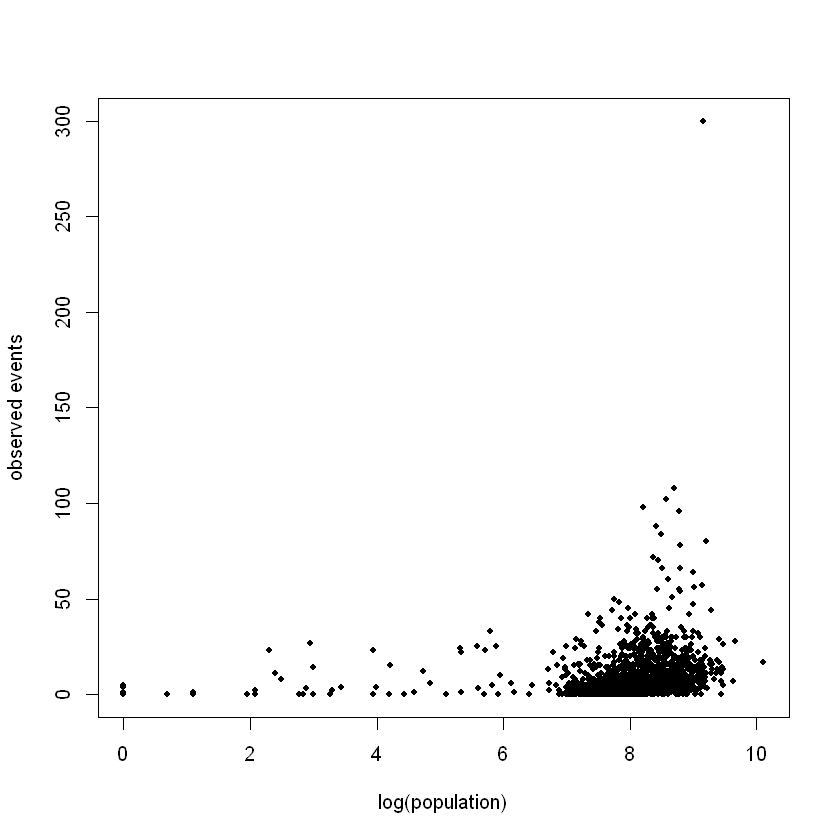

In [45]:
load("nyc_subset.data.R");
plot(log(pop_2001),events_2001,xlab="log(population)",ylab="observed events", pch=20);

In [46]:
library(maptools);
library(spdep);
library(rgdal)
library(rstan);
options(mc.cores = 3);

load("nyc_subset.data.R");
nyc_shp<-readOGR("nycTracts10", layer="nycTracts10");

Warning message:
"package 'maptools' was built under R version 3.4.4"Checking rgeos availability: TRUE
Warning message:
"package 'spdep' was built under R version 3.4.4"Loading required package: spData
Warning message:
"package 'spData' was built under R version 3.4.4"To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Attaching package: 'spData'

The following objects are masked _by_ '.GlobalEnv':

    x, y

Loading required package: sf
Warning message:
"package 'sf' was built under R version 3.4.4"Linking to GEOS 3.6.1, GDAL 2.2.3, proj.4 4.9.3
Warning message:
"package 'rgdal' was built under R version 3.4.4"rgdal: version: 1.3-6, (SVN revision 773)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: D:/Programs/R/R-3.4.1/library/rgdal/gdal
 GDAL binary built with

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\repos\example-models\knitr\car-iar-poisson\nycTracts10", layer: "nycTracts10"
with 2168 features
It has 14 fields
Integer64 fields read as strings:  ALAND10 AWATER10 


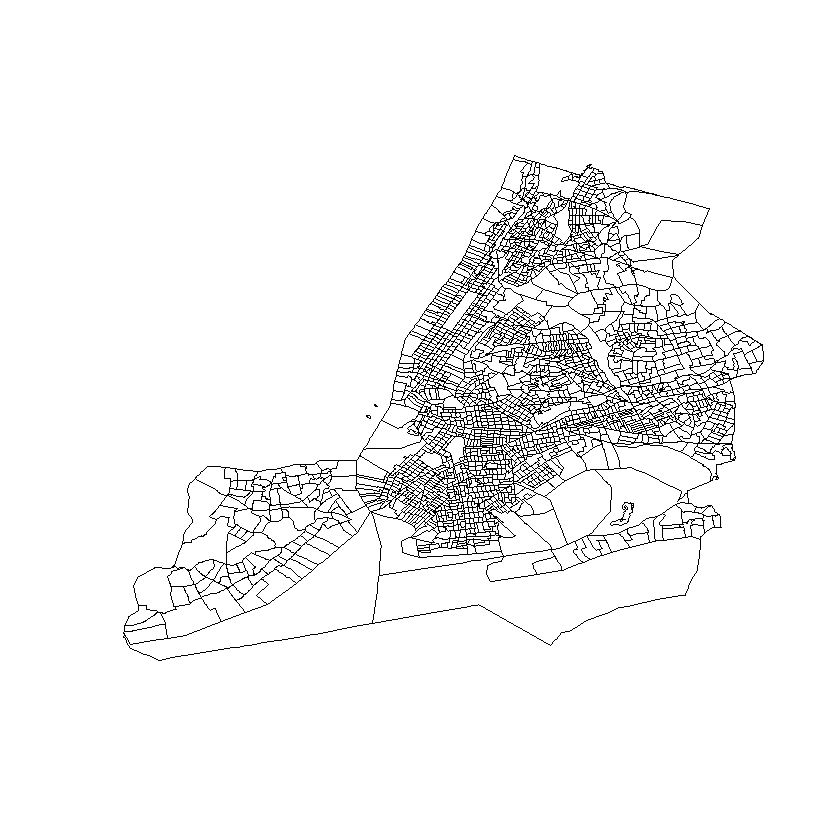

In [48]:
plot(nyc_shp)

In [49]:
geoids <- nyc_shp$GEOID10 %in% nyc_tractIDs;
nyc_subset_shp <- nyc_shp[geoids,];
nyc_subset_shp <- nyc_subset_shp[order(nyc_subset_shp$GEOID10),];
nb_nyc_subset = poly2nb(nyc_subset_shp);

In [50]:
str(nb_nyc_subset)

List of 1921
 $ : int [1:2] 1452 1721
 $ : int [1:5] 3 4 5 7 1721
 $ : int [1:6] 2 4 40 46 1721 1723
 $ : int [1:6] 2 3 5 16 40 52
 $ : int [1:5] 2 4 7 16 22
 $ : int [1:2] 8 17
 $ : int [1:7] 2 5 11 21 22 23 54
 $ : int [1:4] 6 9 10 17
 $ : int [1:3] 8 10 17
 $ : int [1:5] 8 9 13 17 19
 $ : int [1:5] 7 23 24 54 59
 $ : int [1:4] 13 14 44 45
 $ : int [1:6] 10 12 14 15 17 19
 $ : int [1:5] 12 13 15 39 44
 $ : int [1:6] 13 14 19 20 37 39
 $ : int [1:3] 4 5 22
 $ : int [1:6] 6 8 9 10 13 19
 $ : int [1:4] 21 38 43 52
 $ : int [1:5] 10 13 15 17 20
 $ : int [1:5] 15 19 32 37 39
 $ : int [1:7] 7 18 22 23 34 36 38
 $ : int [1:4] 5 7 16 21
 $ : int [1:7] 7 11 21 25 30 31 34
 $ : int [1:4] 11 25 54 59
 $ : int [1:6] 23 24 26 30 59 77
 $ : int [1:4] 25 28 30 77
 $ : int [1:2] 29 95
 $ : int [1:9] 26 30 77 80 110 112 132 193 194
 $ : int [1:4] 27 32 33 89
 $ : int [1:7] 23 25 26 28 31 34 110
 $ : int [1:4] 23 30 34 110
 $ : int [1:5] 20 29 33 37 89
 $ : int [1:5] 29 32 35 37 89
 $ : int [1:5] 21 2

In [51]:
y = events_2001
E = pop_2001;
## set pop > 0 so we can use log(pop) as offset
E[E < 10] = 10;

In [52]:
source("nb_data_funs.R");
nbs=nb2graph(nb_nyc_subset);
N = nbs$N;
node1 = nbs$node1;
node2 = nbs$node2;
N_edges = nbs$N_edges;
scaling_factor = scale_nb_components(nb_nyc_subset)[1];

In [56]:
str(scaling_factor)

 num 0.714


In [57]:
bym2_stan = stan_model("bym2_offset_only.stan");

Loading required package: raster
Warning message:
"package 'raster' was built under R version 3.4.4"
Attaching package: 'raster'

The following objects are masked from 'package:gdata':

    resample, trim

The following object is masked from 'package:rstan':

    extract



In [58]:
writeLines(readLines('bym2_offset_only.stan'))

// use for case study NYC data subset
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]

  int<lower=0> y[N];              // count outcomes
  vector<lower=0>[N] E;           // exposure

  real<lower=0> scaling_factor; // scales the variance of the spatial effects
}
transformed data {
  vector[N] log_E = log(E);
}
parameters {
  real beta0;                // intercept

  real<lower=0> sigma;        // overall standard deviation
  real<lower=0, upper=1> rho; // proportion unstructured vs. spatially structured variance

  vector[N] theta;       // heterogeneous effects
  vector[N] phi;  // spatial effects
}
transformed parameters {
  vector[N] convolved_re;
  // variance of each component should be approximately equal to 1
  convolved_re =  sqrt(1 - rho) * theta + sqrt(rho / scaling_factor) * phi;
}
model {
  y ~ poisson_log(log_E + beta0 + convolv

In [59]:
bym2_fit = sampling(bym2_stan, data=list(N,N_edges,node1,node2,y,E,scaling_factor), control = list(adapt_delta = 0.97), chains=3, warmup=7000, iter=8000, save_warmup=FALSE);

In [60]:
print(bym2_fit, digits=3, pars=c("beta0", "rho", "sigma", "mu[1]", "mu[2]", "mu[3]", "mu[500]", "mu[1000]", "mu[1500]", "mu[1900]", "phi[1]", "phi[2]", "phi[3]", "phi[500]", "phi[1000]", "phi[1500]", "phi[1900]", "theta[1]", "theta[2]", "theta[3]", "theta[500]", "theta[1000]", "theta[1500]", "theta[1900]"), probs=c(0.025, 0.5, 0.975));

Inference for Stan model: bym2_offset_only.
3 chains, each with iter=8000; warmup=7000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

              mean se_mean    sd  2.5%    50%    98% n_eff Rhat
beta0       -6.614   0.000 0.023 -6.66 -6.613 -6.570  2595    1
rho          0.548   0.003 0.040  0.47  0.546  0.626   208    1
sigma        1.188   0.003 0.035  1.12  1.187  1.261   192    1
mu[1]        1.425   0.016 1.003  0.25  1.162  4.003  4129    1
mu[2]        1.596   0.014 1.027  0.31  1.365  4.294  5160    1
mu[3]        0.914   0.010 0.654  0.17  0.741  2.666  4307    1
mu[500]     21.438   0.086 4.662 13.31 21.128 31.822  2930    1
mu[1000]     1.740   0.017 1.092  0.39  1.493  4.599  4271    1
mu[1500]     2.192   0.017 1.181  0.56  1.948  5.081  5070    1
mu[1900]     0.997   0.011 0.731  0.17  0.798  2.971  4289    1
phi[1]      -1.734   0.011 0.656 -3.07 -1.715 -0.479  3431    1
phi[2]      -0.886   0.008 0.469 -1.84 -0.885  0.058  3102    1
phi[3]

In [61]:
save(bym2_fit, file="nyc_bym2_fit.data.R");

In [62]:
writeLines(readLines('pois.stan'))


data {
  int<lower=0> N;
  int<lower=0> y[N];              // count outcomes
  vector<lower=0>[N] E;           // exposure
}
transformed data {
  vector[N] log_E = log(E);
}
parameters {
  real beta0;                // intercept
}
model {
  y ~ poisson_log(log_E + beta0);  // intercept only, no covariates
  beta0 ~ normal(0.0, 2.5);
}
generated quantities {
  vector[N] eta = log_E + beta0;
  vector[N] mu = exp(eta);
}


In [63]:
pois_stan = stan_model("pois.stan");
pois_fit = sampling(pois_stan, data=list(N,y,E), chains=3, save_warmup=FALSE);
print(pois_fit, digits=3, pars=c("beta0", "mu[1]", "mu[2]", "mu[3]", "mu[500]", "mu[1000]", "mu[1500]", "mu[1900]"), probs=c(0.025, 0.5, 0.975));

save(pois_fit, file="nyc_pois_fit.data.R");

Inference for Stan model: pois.
3 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

         mean se_mean    sd 2.5%  50%  98% n_eff Rhat
beta0    -6.1   0.000 0.008 -6.1 -6.1 -6.1  1184    1
mu[1]    27.6   0.006 0.219 27.2 27.6 28.1  1185    1
mu[2]     7.9   0.002 0.063  7.8  7.9  8.1  1185    1
mu[3]     7.7   0.002 0.061  7.6  7.7  7.9  1185    1
mu[500]   7.5   0.002 0.060  7.4  7.5  7.7  1185    1
mu[1000] 11.2   0.003 0.089 11.0 11.2 11.4  1185    1
mu[1500]  4.2   0.001 0.033  4.1  4.2  4.3  1185    1
mu[1900] 11.6   0.003 0.092 11.5 11.6 11.8  1185    1

Samples were drawn using NUTS(diag_e) at Wed Oct 02 17:50:17 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [64]:
writeLines(readLines('pois_re.stan'))

data {
  int<lower=0> N;
  int<lower=0> y[N];              // count outcomes
  vector<lower=0>[N] E;           // exposure
}
transformed data {
  vector[N] log_E = log(E);
}
parameters {
  real beta0;                // intercept
  vector[N] theta;           // heterogeneous random effects
  real<lower=0> sigma;       // non-centered re variance 
}
model {
  y ~ poisson_log(log_E + beta0 + theta * sigma);
  beta0 ~ normal(0.0, 2.5);
  theta ~ normal(0, 1);
  sigma ~ normal(0, 5);
}
generated quantities {
  vector[N] eta = log_E + beta0 + theta * sigma;
  vector[N] mu = exp(eta);
}
